In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import csv
from io import BytesIO

START_DATE = '1/1/2000'
END_DATE = '12/31/2022'


FIPS_CODES= ['13277', '13155', '13075','13071','13321','13287']




In [235]:

urls = []
for i in range(len(FIPS_CODES)):
    AOI = FIPS_CODES[i]
    urls.append(f'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi={AOI}&startdate={START_DATE}&enddate={END_DATE}&statisticsType=1')

In [236]:
urls

['https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13277&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1',
 'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13155&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1',
 'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13075&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1',
 'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13071&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1',
 'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13321&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1',
 'https://usdmdataservices.unl.edu/api/CountyStatistics/GetDsci?aoi=13287&startdate=1/1/2000&enddate=12/31/2022&statisticsType=1']

In [237]:
csvs = []
responses = []
dfs = []
for i in urls:
    r = requests.get(i)
    r.headers['Accept'] = "application/json; charset=utf-8"
    df = pd.read_json(r.content.decode())
    df['date'] = pd.to_datetime(df['MapDate'],infer_datetime_format=False, format="%Y%m%d")
    df.index = df['date']
    df= df.drop(['FIPS','MapDate','State','date'], axis=1)
    df.groupby(['County'], axis=1)
    dfs.append(df)

In [238]:
dfs

[                 County  DSCI
 date                         
 2000-01-04  Tift County   300
 2000-01-11  Tift County   300
 2000-01-18  Tift County   300
 2000-01-25  Tift County   300
 2000-02-01  Tift County   300
 ...                 ...   ...
 2022-11-29  Tift County   200
 2022-12-06  Tift County   200
 2022-12-13  Tift County   200
 2022-12-20  Tift County   200
 2022-12-27  Tift County   200
 
 [1200 rows x 2 columns],
                   County  DSCI
 date                          
 2000-01-04  Irwin County   300
 2000-01-11  Irwin County   300
 2000-01-18  Irwin County   300
 2000-01-25  Irwin County   300
 2000-02-01  Irwin County   300
 ...                  ...   ...
 2022-11-29  Irwin County    58
 2022-12-06  Irwin County    64
 2022-12-13  Irwin County   148
 2022-12-20  Irwin County   148
 2022-12-27  Irwin County   148
 
 [1200 rows x 2 columns],
                  County  DSCI
 date                         
 2000-01-04  Cook County   300
 2000-01-11  Cook County   300
 

In [239]:
keys = [i['County'][0].replace(' ', '_') for i in dfs]
keys

['Tift_County',
 'Irwin_County',
 'Cook_County',
 'Colquitt_County',
 'Worth_County',
 'Turner_County']

In [329]:
df_cat = pd.concat(dfs, keys=keys)
df_cat  = df_cat.drop(['County'],axis=1)
df_cat.index

MultiIndex([(  'Tift_County', '2000-01-04'),
            (  'Tift_County', '2000-01-11'),
            (  'Tift_County', '2000-01-18'),
            (  'Tift_County', '2000-01-25'),
            (  'Tift_County', '2000-02-01'),
            (  'Tift_County', '2000-02-08'),
            (  'Tift_County', '2000-02-15'),
            (  'Tift_County', '2000-02-22'),
            (  'Tift_County', '2000-02-29'),
            (  'Tift_County', '2000-03-07'),
            ...
            ('Turner_County', '2022-10-25'),
            ('Turner_County', '2022-11-01'),
            ('Turner_County', '2022-11-08'),
            ('Turner_County', '2022-11-15'),
            ('Turner_County', '2022-11-22'),
            ('Turner_County', '2022-11-29'),
            ('Turner_County', '2022-12-06'),
            ('Turner_County', '2022-12-13'),
            ('Turner_County', '2022-12-20'),
            ('Turner_County', '2022-12-27')],
           names=[None, 'date'], length=7200)

In [330]:
df_cat = df_cat.rename_axis(['county', 'date'], axis=0)
df = df_cat.reset_index(level='county')
df.head()

,county,DSCI
date,,
2000-01-04,Tift_County,300
2000-01-11,Tift_County,300
2000-01-18,Tift_County,300
2000-01-25,Tift_County,300
2000-02-01,Tift_County,300


In [331]:
df.county.value_counts()

Tift_County        1200
Irwin_County       1200
Cook_County        1200
Colquitt_County    1200
Worth_County       1200
Turner_County      1200
Name: county, dtype: int64

In [332]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)


def create_features(pdf, label=None):
    """
    Creates time series features from datetime index.
    """
    pdf = pdf.copy()
    pdf['date'] = pdf.index
    pdf['quarter'] = pdf['date'].dt.quarter
    pdf['month'] = pdf['date'].dt.month
    pdf['year'] = pdf['date'].dt.year
    pdf['dayofyear'] = pdf['date'].dt.dayofyear
    pdf['dayofmonth'] = pdf['date'].dt.day
    pdf['date_offset'] = (pdf.date.dt.month * 100 + pdf.date.dt.day - 320) % 1300
    pdf['week'] = pdf.index.week

    pdf['season'] = pd.cut(pdf['date_offset'], [0, 300, 602, 900, 1300],
                           labels=['Spring', 'Summer', 'Fall', 'Winter']
                           )
    return pdf

df = create_features(pdf=df)
df

,county,DSCI,date,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season
date,,,,,,,,,,,
2000-01-04,Tift_County,300,2000-01-04,1,1,2000,4,4,1084,1,Winter
2000-01-11,Tift_County,300,2000-01-11,1,1,2000,11,11,1091,2,Winter
2000-01-18,Tift_County,300,2000-01-18,1,1,2000,18,18,1098,3,Winter
2000-01-25,Tift_County,300,2000-01-25,1,1,2000,25,25,1105,4,Winter
2000-02-01,Tift_County,300,2000-02-01,1,2,2000,32,1,1181,5,Winter
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-29,Turner_County,200,2022-11-29,4,11,2022,333,29,809,48,Fall
2022-12-06,Turner_County,193,2022-12-06,4,12,2022,340,6,886,49,Fall
2022-12-13,Turner_County,200,2022-12-13,4,12,2022,347,13,893,50,Fall


In [333]:
df = df.drop(['date'],axis=1)

In [334]:
df

,county,DSCI,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season
date,,,,,,,,,,
2000-01-04,Tift_County,300,1,1,2000,4,4,1084,1,Winter
2000-01-11,Tift_County,300,1,1,2000,11,11,1091,2,Winter
2000-01-18,Tift_County,300,1,1,2000,18,18,1098,3,Winter
2000-01-25,Tift_County,300,1,1,2000,25,25,1105,4,Winter
2000-02-01,Tift_County,300,1,2,2000,32,1,1181,5,Winter
...,...,...,...,...,...,...,...,...,...,...
2022-11-29,Turner_County,200,4,11,2022,333,29,809,48,Fall
2022-12-06,Turner_County,193,4,12,2022,340,6,886,49,Fall
2022-12-13,Turner_County,200,4,12,2022,347,13,893,50,Fall


In [335]:
def add_lags(df):
    target_map = df['DSCI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [336]:
df = add_lags(df)

In [337]:
df.head()

,county,DSCI,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,lag1,lag2,lag3
date,,,,,,,,,,,,,
2000-01-04,Tift_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN
2000-01-11,Tift_County,300,1,1,2000,11,11,1091,2,Winter,NaN,NaN,NaN
2000-01-18,Tift_County,300,1,1,2000,18,18,1098,3,Winter,NaN,NaN,NaN
2000-01-25,Tift_County,300,1,1,2000,25,25,1105,4,Winter,NaN,NaN,NaN
2000-02-01,Tift_County,300,1,2,2000,32,1,1181,5,Winter,NaN,NaN,NaN


In [338]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7200 entries, 2000-01-04 to 2022-12-27
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   county       7200 non-null   object  
 1   DSCI         7200 non-null   int64   
 2   quarter      7200 non-null   int64   
 3   month        7200 non-null   int64   
 4   year         7200 non-null   int64   
 5   dayofyear    7200 non-null   int64   
 6   dayofmonth   7200 non-null   int64   
 7   date_offset  7200 non-null   int64   
 8   week         7200 non-null   int64   
 9   season       7176 non-null   category
 10  lag1         6888 non-null   float64 
 11  lag2         6576 non-null   float64 
 12  lag3         6264 non-null   float64 
dtypes: category(1), float64(3), int64(8), object(1)
memory usage: 738.5+ KB


In [339]:
df['season'] = df['season'].fillna('Spring')
df.isnull().sum(axis=0)

county           0
DSCI             0
quarter          0
month            0
year             0
dayofyear        0
dayofmonth       0
date_offset      0
week             0
season           0
lag1           312
lag2           624
lag3           936
dtype: int64

In [340]:
# I think the dframe is good enough to be exported here
df = df.sort_index()
df.head()
df.to_parquet('../Data/Drought_Monitor_DSCI_Datasets/Multi_County_DSCI_2000_2021.parquet')

In [341]:
df = pd.read_parquet('../Data/Drought_Monitor_DSCI_Datasets/Multi_County_DSCI_2000_2021.parquet')

In [342]:
import seaborn as sns
import warnings
from sklearn import set_config
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

set_config(display='diagram')

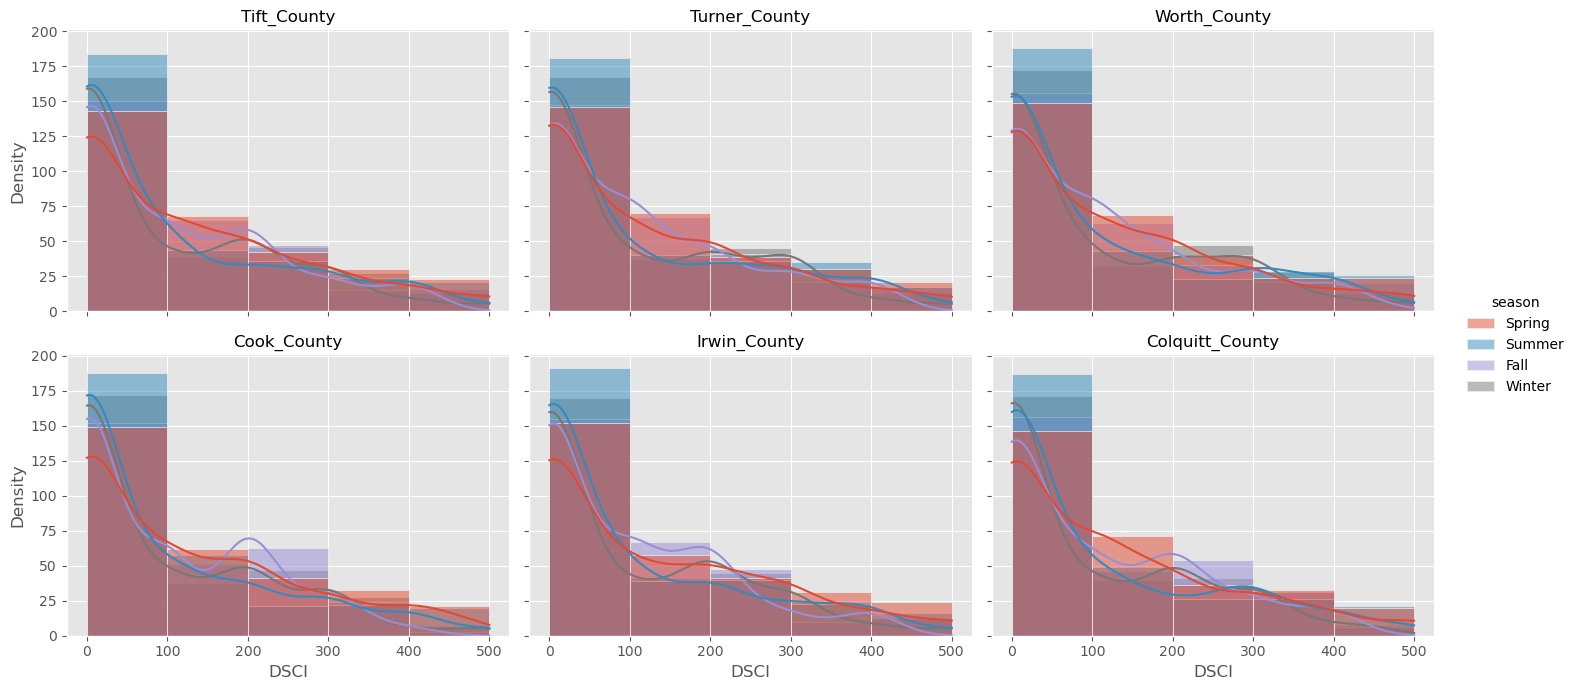

In [343]:


g = sns.displot(df, x='DSCI',bins=5,col='county', hue='season', height=3.5, aspect=1.4, col_wrap=3, kde=True)
g.set_axis_labels("DSCI", "Density")
g.set_titles("{col_name}")

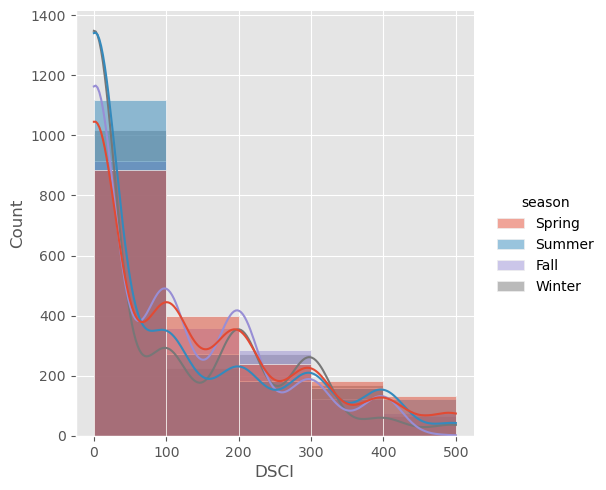

In [344]:
sns.displot(df, x='DSCI',bins=5, hue='season', kde=True)

In [345]:
df['date'] = df.index
df = df.sort_index()
df.head()

,county,DSCI,quarter,month,year,dayofyear,dayofmonth,date_offset,week,season,lag1,lag2,lag3,date
date,,,,,,,,,,,,,,
2000-01-04,Tift_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN,2000-01-04
2000-01-04,Turner_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN,2000-01-04
2000-01-04,Worth_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN,2000-01-04
2000-01-04,Cook_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN,2000-01-04
2000-01-04,Irwin_County,300,1,1,2000,4,4,1084,1,Winter,NaN,NaN,NaN,2000-01-04


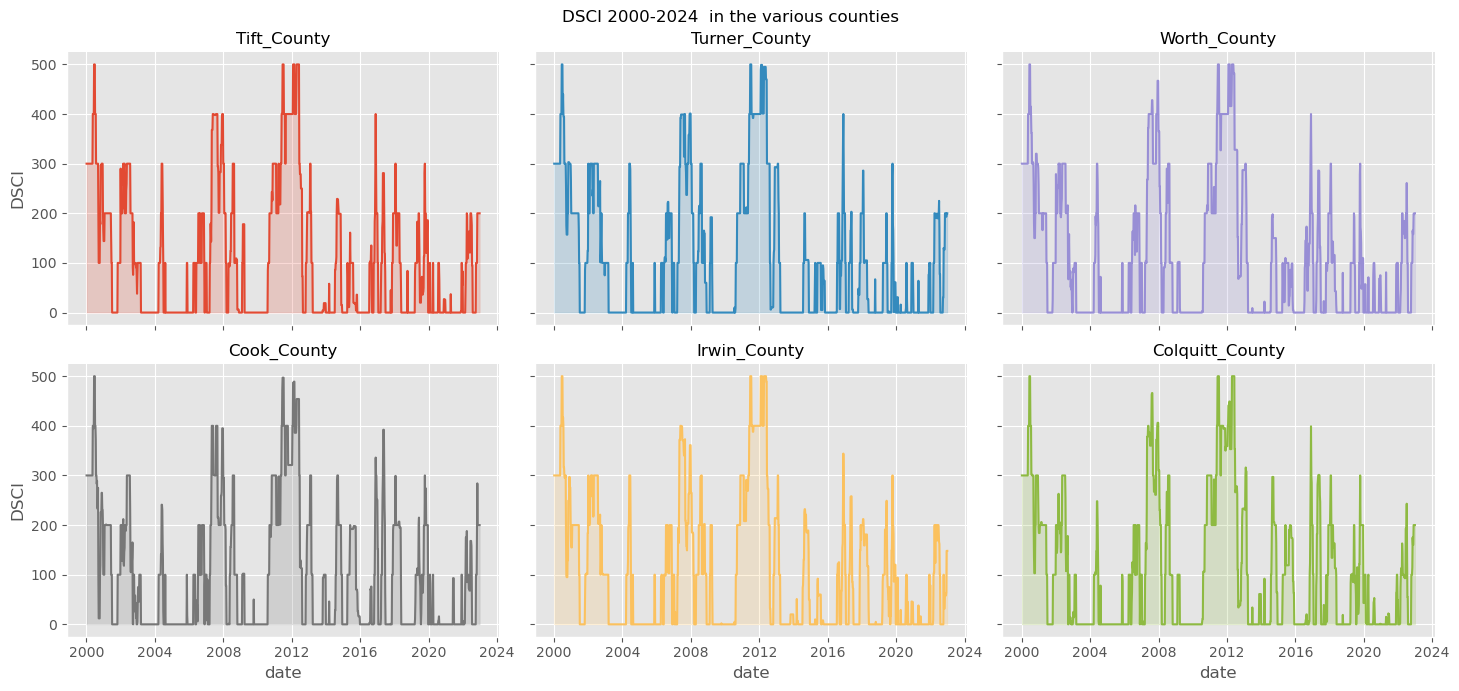

In [346]:
g = sns.FacetGrid(df, col='county', col_wrap=3, hue='county', height=3.5, aspect=1.4)
g =g.map(plt.plot,'date','DSCI')
g = g.map(plt.fill_between,'date','DSCI', alpha=0.2).set_titles("{col_name}")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('DSCI 2000-2024  in the various counties')
plt.show()


In [347]:
print('Start Date:', df.index.min())
print('End Date:', df.index.max())

Start Date: 2000-01-04 00:00:00
End Date: 2022-12-27 00:00:00


In [349]:
list(df.county.unique())

['Tift_County',
 'Turner_County',
 'Worth_County',
 'Cook_County',
 'Irwin_County',
 'Colquitt_County']